In [3]:
#ref: https://doi.org/10.1063/1.5001823 Fig.2
import numpy as np
from numpy import sqrt, array, zeros, ones, exp, abs, matmul, linspace, pi
import matplotlib.pyplot as plt
%matplotlib inline

hbar = 1.0545e-34   # Js 
m0   = 9.1094e-31   # kg
qe   = 1.602e-19    # C
hbr  = 6.5821e-16   # eV.s
kb   = 8.617333e-5  # eV/K
zi   = 1.0j

#this section contains general functions

def wavenum(energy,mass,potential):
    s  = 2*qe*m0*1e-18/(hbar**2)
    if (energy < potential):
        return zi*sqrt(s*mass*(potential-energy))
    elif (energy==potential):
        return 1e-6
    else:
        return sqrt(s*mass*(energy-potential))

def matD(energy,mass,potential,mass1,potential1):
    delta = wavenum(energy,mass1,potential1)*mass \
            /(wavenum(energy,mass,potential)*mass1)
    return 0.5*array([[(1+delta), (1-delta)],
                      [(1-delta), (1+delta)]])

def matP(energy,mass,potential,thickness):
    k = wavenum(energy,mass,potential)
    return array([[exp(-zi*k*thickness), 0                  ],
                  [0                   , exp(zi*k*thickness)]])

def matT(energy,mass,potential,thickness,Npot):
    PD = array([[1,0],[0,1]])
    for q in range(1,Npot+1):
        PE = matP(energy,mass[q],potential[q],thickness[q])
        DE = matD(energy,mass[q],potential[q],mass[q+1],potential[q+1])
        PD = PD @ (PE @ DE)
    return matD(energy,mass[0],potential[0],mass[1],potential[1]) @ PD

def transmission(energy, mass, potential, thickness):
    numE  = len(energy)
    Npot  = len(potential)-2
    trans = zeros(numE,float)
    for i in range(0,numE):
        T = matT(energy[i],mass,potential,thickness,Npot)
        trans[i] = 1 - (abs(T[1,0])/abs(T[0,0]))**2
        if (trans[i] <= 1e-14):
            trans[i] = 1e-17        
        
    return trans

In [4]:
#generate voltage profile
def V(pos, potential, thickness, Vbias):
    numth = len(thickness)
    maxP  = sum(thickness)
    
    bias  = Vbias/sum(thickness[1:-1])
    pos   = pos - thickness[0]

    b = zeros(numth,float)
    for j in range(numth):
        b[j] = sum(thickness[0:j+1])*numV/maxP
    
    potprof = zeros(numV,float)
    for i in range(numV):
        j = 0
        while (i >= b[j]):
            j += 1
            if j >= numth:
                break
                
        if (i < b[0]):
            potprof[i] = potential[j] + Vbias
        elif (i > b[numth-2]):
            potprof[i] = potential[j] 
        else:
            potprof[i] = -bias*pos[i] + potential[j] + Vbias 
    return potprof

#array of grid widths
def tebal(pos, thickness): 
    numV = len(pos)
    d = ones(numV,float)
    tebal = d*sum(thickness)/numV
    return tebal

#array of constant mass (for simple calculation)
def massarray(pos, mass, thickness):
    numV  = len(pos)
    numth = len(thickness)
    maxP  = sum(thickness)
    
    b = zeros(numth,float)
    for j in range(numth):
        b[j] = sum(thickness[0:j+1])*numV/maxP
    
    m1 = zeros(numV,float)
    for i in range(numV):
        j = 0
        while (i >= b[j]):
            j += 1
            if j >= numth:
                break
        m1[i] = mass[j] 
    return m1

In [5]:
def JTc(mass, potential, thickness, Vbias, Ef, T, numV, numE):
    numB      = len(Vbias)
    cm        = 1e-4 
    prefactor = qe*m0/(2*(pi**2)*(hbr**3))*cm 
    
    pos       = linspace(0, sum(thickness), numV)
    m1        = massarray(pos, mass, thickness)
    teball    = tebal(pos, thickness)
    
    Jv = zeros(numB,float)
    if (T == 0):
        for i in range(numB):
            clpot     = V(pos, potential, thickness, Vbias[i])
            if (Vbias[i] <= Ef):
                energy1 = linspace(Vbias[i], Ef, numE)
                energy2 = linspace(Ef, Vbias[i]+Ef, numE)
                cleta1  = transmission(energy1, m1, clpot, teball)
                cleta2  = transmission(energy2, m1, clpot, teball)
                
                Jv1     = Vbias[i]*np.trapz(cleta1, x=energy1)
                Jv2     = np.trapz((Ef+Vbias[i]-energy2)*cleta2, x=energy2)
                Jv[i]   = Jv1 + Jv2
            else:
                energy  = linspace(Vbias[i], Vbias[i]+Ef, numE)
                cleta   = transmission(energy, m1, clpot, teball)
                                
                Jv[i]   = np.trapz((Ef+Vbias[i]-energy)*cleta, x=energy)
        Jv = Jv*prefactor/qe
    else:
        inff = max(potential)+max(Vbias)
        for i in range(numB):
            energy  = linspace(Vbias[i], inff, numE)
            clpot   = V(pos, potential, thickness, Vbias[i])
            cleta   = transmission(energy, m1, clpot, teball)
            
            S       = (1+exp((Ef+Vbias[i]-energy)/(kb*T)))/(1+exp((Ef-energy)/(kb*T)))
            Jv[i]   = np.trapz(cleta*np.log(S), x=energy)
        Jv = Jv*prefactor*kb*T
    return Jv

In [6]:
numV      = 300
numE      = 300
numB      = 100
Ef        = 0.15
T         = 0
Vbias     = linspace(-5, 5, numB)

In [7]:
#single well potential

potential1 = array([0, 0.2, 0, 0.2, 0])
potential2 = array([0, 0.4, 0, 0.4, 0])
potential3 = array([0, 0.6, 0, 0.6, 0])
potential4 = array([0, 0.8, 0, 0.8, 0])

mass      = array([1, 1, 1, 1, 1])
thickness = array([1, 1, 1, 1, 1])

Jv_single1 = JTc(mass, potential1, thickness, Vbias, Ef, T, numV, numE)
Jv_single2 = JTc(mass, potential2, thickness, Vbias, Ef, T, numV, numE)
Jv_single3 = JTc(mass, potential3, thickness, Vbias, Ef, T, numV, numE)
Jv_single4 = JTc(mass, potential4, thickness, Vbias, Ef, T, numV, numE)


In [8]:
#double well potential

potential1 = array([0, 0.2, 0, 0.2, 0, 0.2, 0])
potential2 = array([0, 0.4, 0, 0.4, 0, 0.4, 0])
potential3 = array([0, 0.6, 0, 0.6, 0, 0.6, 0])
potential4 = array([0, 0.8, 0, 0.8, 0, 0.8, 0])

mass      = array([1, 1, 1, 1, 1, 1, 1])
thickness = array([1, 1, 1, 1, 1, 1, 1])

Jv_double1 = JTc(mass, potential1, thickness, Vbias, Ef, T, numV, numE)
Jv_double2 = JTc(mass, potential2, thickness, Vbias, Ef, T, numV, numE)
Jv_double3 = JTc(mass, potential3, thickness, Vbias, Ef, T, numV, numE)
Jv_double4 = JTc(mass, potential4, thickness, Vbias, Ef, T, numV, numE)

In [ ]:
#triple well potential

potential1 = array([0, 0.2, 0, 0.2, 0, 0.2, 0, 0.2, 0])
potential2 = array([0, 0.4, 0, 0.4, 0, 0.4, 0, 0.4, 0])
potential3 = array([0, 0.6, 0, 0.6, 0, 0.6, 0, 0.6, 0])
potential4 = array([0, 0.8, 0, 0.8, 0, 0.8, 0, 0.8, 0])

mass      = array([1, 1, 1, 1, 1, 1, 1, 1, 1])
thickness = array([1, 1, 1, 1, 1, 1, 1, 1, 1])

Jv_triple1 = JTc(mass, potential1, thickness, Vbias, Ef, T, numV, numE)
Jv_triple2 = JTc(mass, potential2, thickness, Vbias, Ef, T, numV, numE)
Jv_triple3 = JTc(mass, potential3, thickness, Vbias, Ef, T, numV, numE)
Jv_triple4 = JTc(mass, potential4, thickness, Vbias, Ef, T, numV, numE)

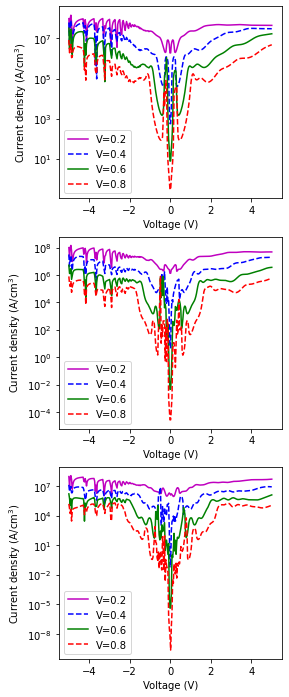

In [ ]:
fig01 = plt.figure(figsize=(4,12))
ax    = fig01.add_subplot(3,1,1)
ax.plot(Vbias,abs(Jv_single1),'m-', Vbias,abs(Jv_single2),'b--', Vbias,abs(Jv_single3),'g-', Vbias,abs(Jv_single4),'r--')
ax.set_xlabel('Voltage (V)')
ax.set_ylabel('Current density (A/cm$^3$)')
plt.yscale('log')
plt.legend(('V=0.2','V=0.4','V=0.6','V=0.8'),loc="best")

ax    = fig01.add_subplot(3,1,2)
ax.plot(Vbias,abs(Jv_double1),'m-', Vbias,abs(Jv_double2),'b--', Vbias,abs(Jv_double3),'g-', Vbias,abs(Jv_double4),'r--')
ax.set_xlabel('Voltage (V)')
ax.set_ylabel('Current density (A/cm$^3$)')
plt.yscale('log')
plt.legend(('V=0.2','V=0.4','V=0.6','V=0.8'),loc="best")

ax    = fig01.add_subplot(3,1,3)
ax.plot(Vbias,abs(Jv_triple1),'m-', Vbias,abs(Jv_triple2),'b--', Vbias,abs(Jv_triple3),'g-', Vbias,abs(Jv_triple4),'r--')
ax.set_xlabel('Voltage (V)')
ax.set_ylabel('Current density (A/cm$^3$)')
plt.yscale('log')
plt.legend(('V=0.2','V=0.4','V=0.6','V=0.8'),loc="best")
plt.savefig('Fig4-JV-curve.pdf')